# Image Visualization

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny


def plot_images(images, titles, cmap='gray'):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image, cmap=cmap)
        ax[i].set_title(title)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

# Line Detection

In [95]:
def find_line(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180,
                            threshold=25, minLineLength=100, maxLineGap=65)
    lines = sorted(lines, key=lambda x: np.linalg.norm(
        x[0][0:2] - x[0][2:4]), reverse=True)
    x1, y1, x2, y2 = lines[0][0]

    # Draw the line on the image with a colored boundary
    line_image = np.zeros_like(image)
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 3)
    line_with_boundary = cv2.addWeighted(image, 0.7, line_image, 0.3, 0)
    print('The Coordinates of the line are: ', x1, y1, x2, y2)

    return x1, y1, x2, y2, line_with_boundary

# Image Transformation

In [96]:
def crop_image(image, x1, y1, x2, y2, margin=110, space_below_line=-2):
    min_x = max(min(x1, x2) - margin, 0)
    max_x = min(max(x1, x2) + margin, image.shape[1])
    min_y = max(min(y1, y2) - margin, 0)
    max_y = min(max(y1, y2) + margin + space_below_line, image.shape[0])
    cropped = image[min_y:max_y, min_x:max_x]

    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi

    # Rotate the image
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated = cv2.warpAffine(image, M, (cols, rows))

    # Calculate the center of the image
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Define the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1)

    # Rotate the four points
    pts = np.array([(x1 - margin, y1 - margin), (x1, y1), (x2, y2), (x2 - margin, y2 - margin)])
    pts_rotated = cv2.transform(pts.reshape(-1, 1, 2), M).reshape(-1, 2).astype(int)

    # Crop the image
    cropped = rotated[pts_rotated[0][1] - space_below_line:pts_rotated[2][1] + space_below_line,
              pts_rotated[0][0]-20 :pts_rotated[2][0]+20 ]

    plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)],
                ['Original Image with line', 'Cropped and Rotated image'])

    return cropped

# Channel Separation

In [97]:
def split_channels(image):
    blue, green, red = cv2.split(image)
    # Plot the RGB channels
    plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.cvtColor(red, cv2.COLOR_BGR2RGB),
                 cv2.cvtColor(green, cv2.COLOR_BGR2RGB), cv2.cvtColor(blue, cv2.COLOR_BGR2RGB)],
                ['RGB', 'Red channel', 'Green channel', 'Blue channel'])
    return blue, green, red

# Contrast Enhancement

In [98]:
def enhance_contrast(image):
    # Apply histogram equalization
    enhanced = cv2.equalizeHist(image)
    return enhanced

# Noise Reduction

In [99]:
def denoise_image(image):
    # Apply Gaussian blur to the image
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    median_filtered = cv2.medianBlur(blur, 1)

    return median_filtered

# Feature Detection

In [100]:
def segment_capillaries(image):
    # Apply adaptive thresholding to segment the capillaries
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=31, C=5)

    # Apply Canny edge detection
    edges = canny(thresh, sigma=10)

    contours, hierarchy = cv2.findContours(edges.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the original image
    contour_img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 2)

    # Display the results
    plot_images([cv2.cvtColor(image, cv2.COLOR_BGR2RGB), thresh, contour_img],
                ['Original', 'Threshold', f'Capillaries ({len(contours)})'])

# Processing Pipeline

The Coordinates of the line are:  470 447 861 440


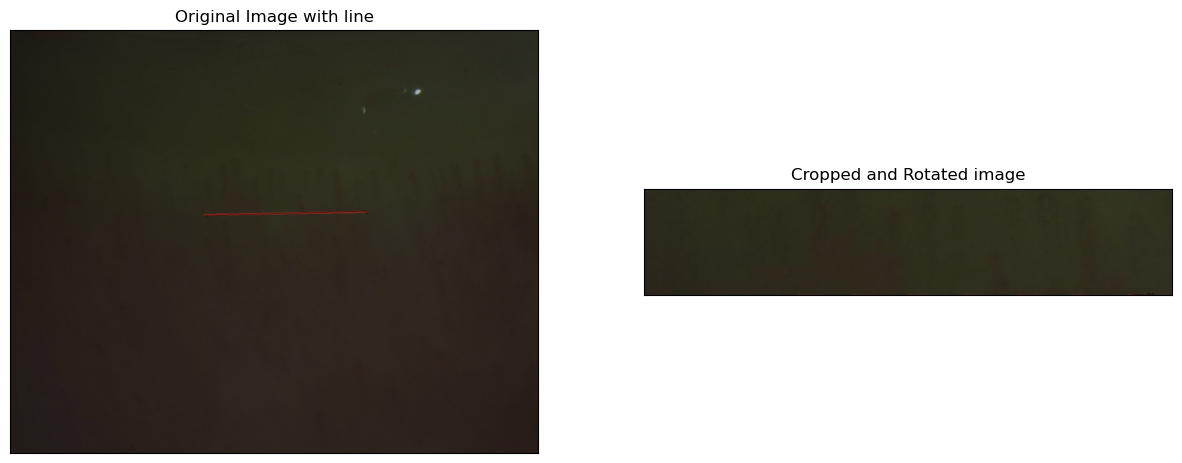

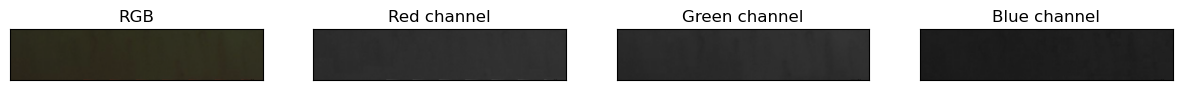

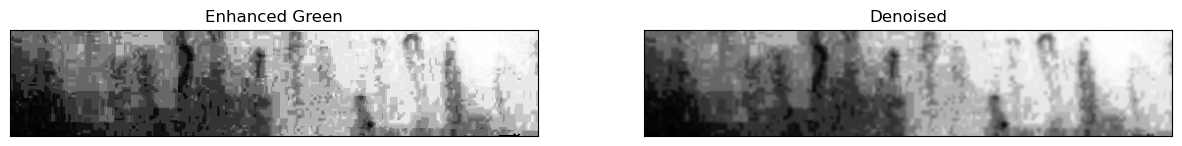

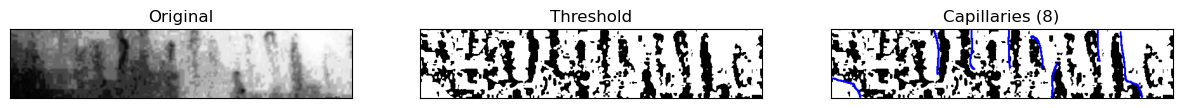

In [101]:
# Read the image
image = cv2.imread(r'Input Images/N2b.jpg', cv2.IMREAD_COLOR)

# Find the line in the image
x1, y1, x2, y2, line_with_boundary = find_line(image)

# Crop the image based on the line
cropped_image = crop_image(line_with_boundary, x1, y1, x2, y2)

# Split the image into its RGB channels
blue, green, red = split_channels(cropped_image)

# Enhance contrast of the green channel
enhanced_green = enhance_contrast(green)

# Denoising
denoised_image = denoise_image(enhanced_green)


# Display the original and denoised images
plot_images([enhanced_green, denoised_image], ['Enhanced Green', 'Denoised'], cmap='gray')

# Contouring
segment_capillaries(denoised_image)